In [1]:
import os
import sys
# sys.path.append('/Users/evanli/Documents/EvanPys/Progress')
# sys.path.append('/home/evanlee/PBMC_Hao')
# sys.path.append('/home/jovyan/work/GitHub/EvanPys/Progress')
sys.path.append(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress')
from ADlasso2 import AD2_w_utils_loss as ad

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import copy


In [3]:
data = sc.read_h5ad(r"C:\Research_datasets_main\Hao_PBMC.h5ad")

In [4]:
data.shape

(161764, 20568)

## Level1: Prevalence boxplot for each celltype (exclude prevalence = 0)

In [5]:
# Level 1
data.obs['celltype.l1'] = data.obs['celltype.l1'].str.replace(' ', '_')
label_l1 = data.obs['celltype.l1'].tolist()
types_l1 = np.unique(label_l1).tolist()
print('all cell types:', types_l1)

all cell types: ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


In [6]:
def prevalence_distribution(data, celltype, label, level='celltype.l1'):
    ### Remove the genes whose expression is zero
    # make a copy of the original anndata object
    adata = copy.deepcopy(data)
    adata_celltype = adata[adata.obs[level] == celltype]
    print('adata celltype shape:', adata_celltype.shape)

    # Remove explicit zeros from the sparse matrix
    adata_celltype.X.eliminate_zeros()

    # Find the columns that are all zeros
    all_zeros = np.where(adata_celltype.X.getnnz(axis=0) == 0)[0]

    # Remove the columns that are all zeros from the anndata object
    adata = adata[:, ~adata_celltype.var_names.isin(adata_celltype.var_names[all_zeros])]
    print('adata shape after removing all zero columns for celltype cells:', adata.shape)
    del adata_celltype, all_zeros

    # Calculate the prevalence of each gene
    # Binary classification of a celltype
    celltype_label = [1 if x == celltype else 0 for x in label]
    # celltype_indices 紀錄屬於該celltype的cell的index
    celltype_indices = [idx for idx, lab in enumerate(celltype_label) if lab == 1]
    prevalence = ad.get_prevalence(adata.X, celltype_indices)

    return prevalence

In [7]:
# calculate prevalence for each cell type
prevalence_dict = {}
for celltype in types_l1:
    print('cell type:', celltype)
    prevalence_dict[celltype] = prevalence_distribution(data, celltype, label_l1, level='celltype.l1')

cell type: B
adata celltype shape: (13800, 20568)
adata shape after removing all zero columns for celltype cells: (161764, 19167)
cell type: CD4_T
adata celltype shape: (41001, 20568)
adata shape after removing all zero columns for celltype cells: (161764, 19633)
cell type: CD8_T
adata celltype shape: (25469, 20568)
adata shape after removing all zero columns for celltype cells: (161764, 19431)
cell type: DC
adata celltype shape: (3589, 20568)
adata shape after removing all zero columns for celltype cells: (161764, 18716)
cell type: Mono
adata celltype shape: (49010, 20568)
adata shape after removing all zero columns for celltype cells: (161764, 20097)
cell type: NK
adata celltype shape: (18664, 20568)
adata shape after removing all zero columns for celltype cells: (161764, 19132)
cell type: other
adata celltype shape: (3442, 20568)
adata shape after removing all zero columns for celltype cells: (161764, 17879)
cell type: other_T
adata celltype shape: (6789, 20568)
adata shape after re

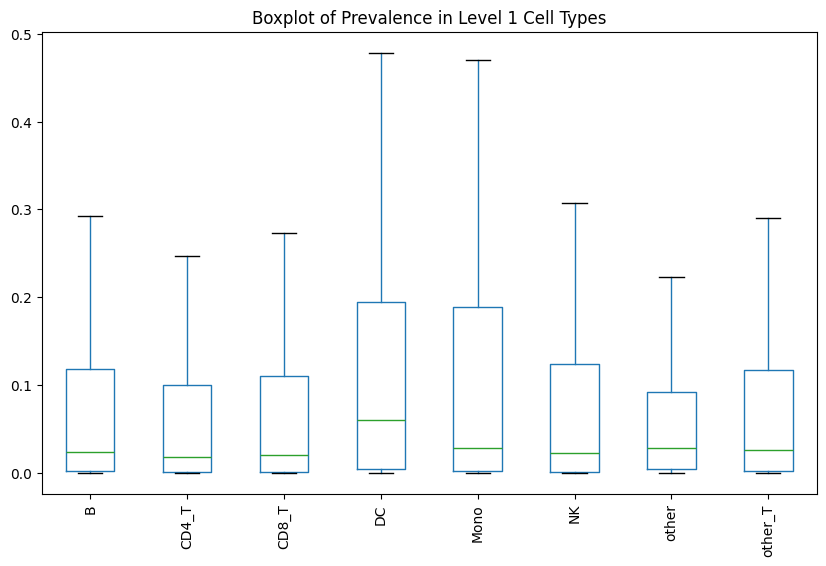

In [8]:
### Prevalence boxplot
# Convert dictionary to DataFrame
df = pd.DataFrame.from_dict(prevalence_dict, orient='index')
# Transpose the DataFrame so that each row corresponds to a box in the boxplot
df = df.transpose()

# Create boxplot without outliers and grid lines
plt.figure(figsize=(10, 6))
df.boxplot(showfliers=False)
plt.xticks(rotation=90)
plt.title('Boxplot of Prevalence in Level 1 Cell Types')
plt.grid(False)
plt.show()

{'B': 19167, 'CD4_T': 19633, 'CD8_T': 19431, 'DC': 18716, 'Mono': 20097, 'NK': 19132, 'other': 17879, 'other_T': 18180}


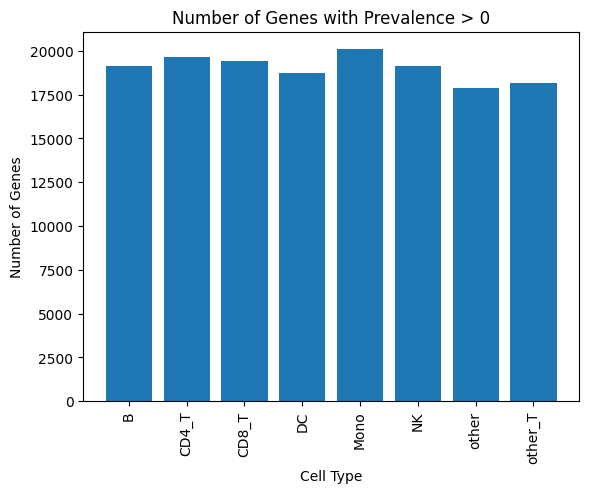

In [9]:
### Barplot of the number of genes with prevalence > 0
# Calculate the number of genes with prevalence > 0 for each cell type
num_genes = {}
for celltype in types_l1:
    pvl = prevalence_dict[celltype]
    num_genes[celltype] = len(pvl[pvl > 0])
print(num_genes)

plt.bar(num_genes.keys(), num_genes.values())
plt.xlabel('Cell Type')
plt.ylabel('Number of Genes')
plt.title('Number of Genes with Prevalence > 0')
plt.xticks(rotation=90)
plt.show()

{'B': 1743, 'CD4_T': 1567, 'CD8_T': 1725, 'DC': 2669, 'Mono': 3155, 'NK': 1976, 'other': 1392, 'other_T': 1706}


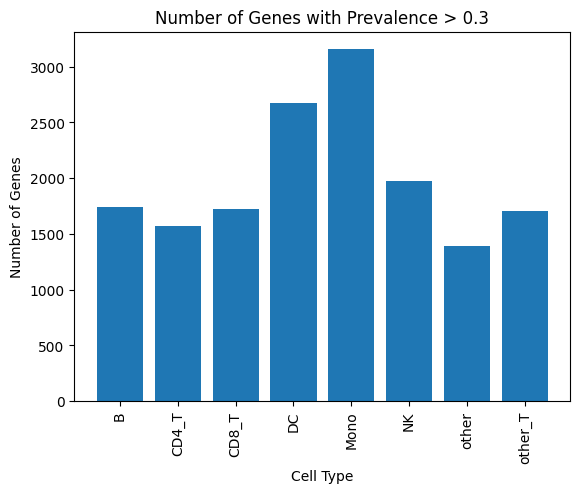

In [10]:
### Barplot of the number of genes with prevalence > 0.3
# Calculate the number of genes with prevalence > 0.3 for each cell type
num_genes = {}
for celltype in types_l1:
    pvl = prevalence_dict[celltype]
    num_genes[celltype] = len(pvl[pvl > 0.3])
print(num_genes)

plt.bar(num_genes.keys(), num_genes.values())
plt.xlabel('Cell Type')
plt.ylabel('Number of Genes')
plt.title('Number of Genes with Prevalence > 0.3')
plt.xticks(rotation=90)
plt.show()

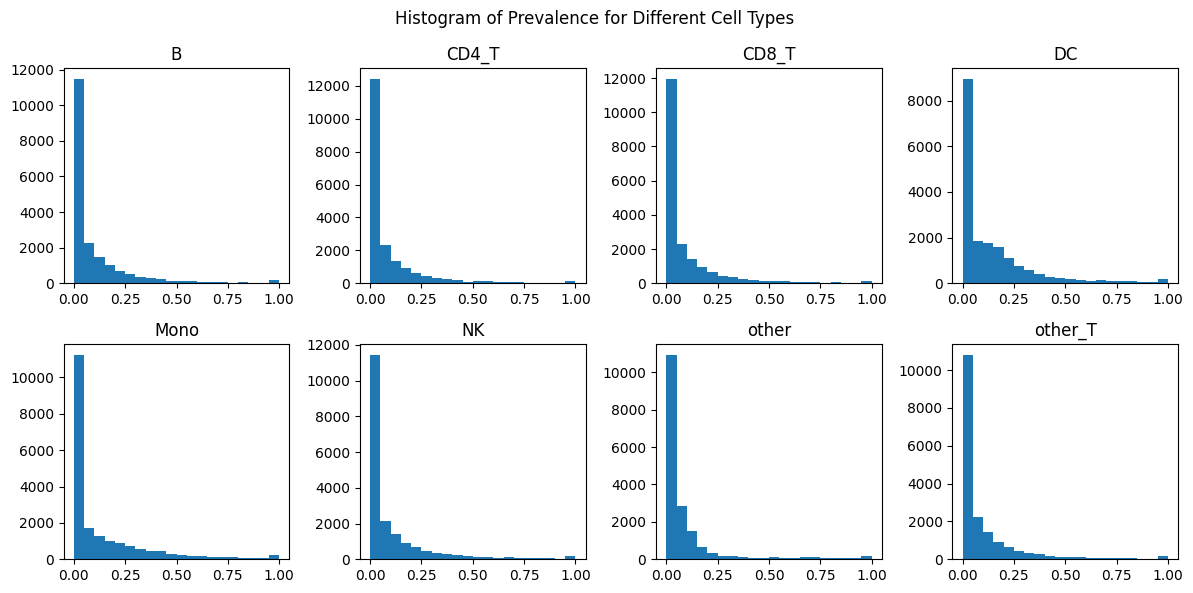

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over the cell types and plot a histogram for each one
for i, celltype in enumerate(prevalence_dict.keys()):
    ax = axes[i]  # Get the current subplot
    prevalence = prevalence_dict[celltype]  # Get the prevalence values for the current cell type
    
    # Plot the histogram
    ax.hist(prevalence, bins=20)
    ax.set_title(celltype)  # Set the title for the subplot

# Remove any extra subplots
if len(prevalence_dict) < len(axes):
    for j in range(len(prevalence_dict), len(axes)):
        fig.delaxes(axes[j])

# Add main title
fig.suptitle('Histogram of Prevalence for Different Cell Types')

# Adjust the spacing between subplots
fig.tight_layout()


# Show the plot
plt.show()


## Level2: Prevalence boxplot for each celltype (exclude prevalence = 0)

In [12]:
# Level 2
data.obs['celltype.l2'] = data.obs['celltype.l2'].str.replace(' ', '_')
label_l2 = data.obs['celltype.l2'].tolist()
types_l2 = np.unique(label_l2).tolist()
print('all cell types:', types_l2)

all cell types: ['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


In [13]:
prevalence_dict_l2 = {}
for celltype in types_l2:
    print('cell type:', celltype)
    prevalence_dict_l2[celltype] = prevalence_distribution(data, celltype, label_l2, level='celltype.l2')

cell type: ASDC
adata celltype shape: (76, 20568)
adata shape after removing all zero columns for celltype cells: (161764, 12605)
cell type: B_intermediate
adata celltype shape: (2431, 20568)
adata shape after removing all zero columns for celltype cells: (161764, 17556)
cell type: B_memory
adata celltype shape: (3285, 20568)
adata shape after removing all zero columns for celltype cells: (161764, 17894)
cell type: B_naive
adata celltype shape: (7718, 20568)
adata shape after removing all zero columns for celltype cells: (161764, 18356)
cell type: CD14_Mono
adata celltype shape: (42690, 20568)
adata shape after removing all zero columns for celltype cells: (161764, 20048)
cell type: CD16_Mono
adata celltype shape: (6320, 20568)
adata shape after removing all zero columns for celltype cells: (161764, 18559)
cell type: CD4_CTL
adata celltype shape: (1736, 20568)
adata shape after removing all zero columns for celltype cells: (161764, 16112)
cell type: CD4_Naive
adata celltype shape: (174

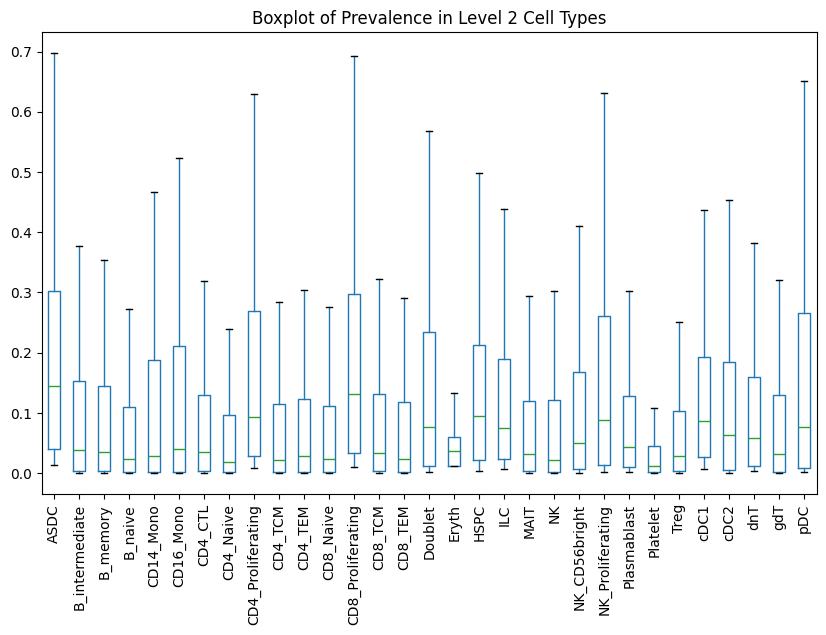

In [14]:
### Prevalence boxplot
# Convert dictionary to DataFrame
df = pd.DataFrame.from_dict(prevalence_dict_l2, orient='index')
# Transpose the DataFrame so that each row corresponds to a box in the boxplot
df = df.transpose()

# Create boxplot without outliers and grid lines
plt.figure(figsize=(10, 6))
df.boxplot(showfliers=False)
plt.xticks(rotation=90)
plt.title('Boxplot of Prevalence in Level 2 Cell Types')
plt.grid(False)
plt.show()

{'ASDC': 12605, 'B_intermediate': 17556, 'B_memory': 17894, 'B_naive': 18356, 'CD14_Mono': 20048, 'CD16_Mono': 18559, 'CD4_CTL': 16112, 'CD4_Naive': 18881, 'CD4_Proliferating': 12853, 'CD4_TCM': 18841, 'CD4_TEM': 17564, 'CD8_Naive': 18508, 'CD8_Proliferating': 12801, 'CD8_TCM': 17067, 'CD8_TEM': 18754, 'Doublet': 15896, 'Eryth': 10407, 'HSPC': 15319, 'ILC': 12505, 'MAIT': 16524, 'NK': 19010, 'NK_CD56bright': 15725, 'NK_Proliferating': 15527, 'Plasmablast': 14577, 'Platelet': 15864, 'Treg': 16354, 'cDC1': 13766, 'cDC2': 18152, 'dnT': 13855, 'gdT': 17612, 'pDC': 16543}


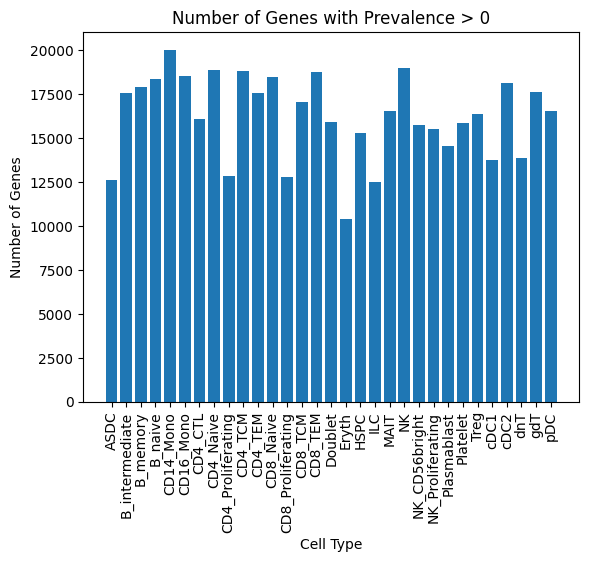

In [15]:
### Barplot of the number of genes with prevalence > 0
# Calculate the number of genes with prevalence > 0 for each cell type
num_genes = {}
for celltype in types_l2:
    pvl = prevalence_dict_l2[celltype]
    num_genes[celltype] = len(pvl[pvl > 0])
print(num_genes)

plt.bar(num_genes.keys(), num_genes.values())
plt.xlabel('Cell Type')
plt.ylabel('Number of Genes')
plt.title('Number of Genes with Prevalence > 0')
plt.xticks(rotation=90)
plt.show()

{'ASDC': 3195, 'B_intermediate': 2095, 'B_memory': 2042, 'B_naive': 1569, 'CD14_Mono': 3163, 'CD16_Mono': 3173, 'CD4_CTL': 1660, 'CD4_Naive': 1435, 'CD4_Proliferating': 2866, 'CD4_TCM': 1737, 'CD4_TEM': 1710, 'CD8_Naive': 1653, 'CD8_Proliferating': 3150, 'CD8_TCM': 1772, 'CD8_TEM': 1801, 'Doublet': 2941, 'Eryth': 284, 'HSPC': 2306, 'ILC': 1728, 'MAIT': 1562, 'NK': 1947, 'NK_CD56bright': 2076, 'NK_Proliferating': 3308, 'Plasmablast': 1511, 'Platelet': 1363, 'Treg': 1211, 'cDC1': 2224, 'cDC2': 2397, 'dnT': 1566, 'gdT': 1839, 'pDC': 3630}


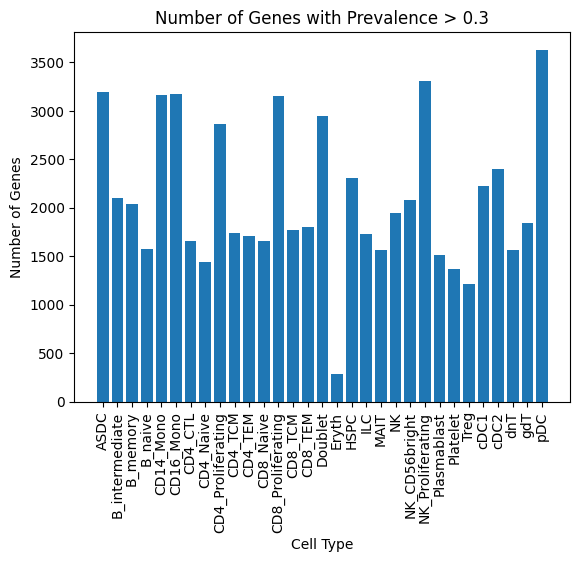

In [16]:
### Barplot of the number of genes with prevalence > 0.3
# Calculate the number of genes with prevalence > 0.3 for each cell type
num_genes = {}
for celltype in types_l2:
    pvl = prevalence_dict_l2[celltype]
    num_genes[celltype] = len(pvl[pvl > 0.3])
print(num_genes)

plt.bar(num_genes.keys(), num_genes.values())
plt.xlabel('Cell Type')
plt.ylabel('Number of Genes')
plt.title('Number of Genes with Prevalence > 0.3')
plt.xticks(rotation=90)
plt.show()